# Dataset: Trackster neighborhood with PU

- select a trackster having at least 50% of the simtrackster energy (0.5 from the associator) and energy above 10GeV
- connect its barycenter to (0,0,0), that gives the trackster axis
- draw a cylinder along this axis, 10cm wide, going 3 layers (or 10cm) before and after the first/last layer-cluster
- connect to all tracksters with a barycenter within this cone (star-like labels)
- labels based on the associator score (can even be binary)
- start with photons, 90% of them are fine, we just wanna fix the remaining 10%
- if we are doing well here, we can go to pions which are much more fragmented
- cut off at 0.2 but can include events with no edges too

Physics evaluation
- plug it into the CMSSW

Method evaluation
- based on precision and recall
    - precision: 2 LC from RECO (within the cone?) also together in SIM
        - how much mess I got in?
    - recall: 2 LC from SIM together in RECO
        - how good did I do on the connecting?


In [93]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from reco.features import get_min_max_z_points
from reco.datasetPU import get_trackster_representative_points, get_tracksters_in_cone, get_major_PU_tracksters

ds_name = "CloseByGamma200PUFull"
file_name = "new_ntuples_15410634_1.root"

# ds_name = "SinglePion200PU"
# file_name = "new_ntuples_15455079_0.root"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"

tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})

clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})

clusters_x = clusters["position_x"].array()
clusters_y = clusters["position_y"].array()
clusters_z = clusters["position_z"].array()
clusters_e = clusters["energy"].array()

reco2sim_index_ = associations["tsCLUE3D_recoToSim_SC"].array()
reco2sim_shared_ = associations["tsCLUE3D_recoToSim_SC_sharedE"].array()
reco2sim_score_ = associations["tsCLUE3D_recoToSim_SC_score"].array()

raw_energy_ = tracksters["raw_energy"].array()
sim_raw_energy_ = simtracksters["stsSC_raw_energy"].array()

barycenter_x_ = tracksters["barycenter_x"].array()
barycenter_y_ = tracksters["barycenter_y"].array()
barycenter_z_ = tracksters["barycenter_z"].array()

vertices_multi_ = tracksters["vertices_multiplicity"].array()
vertices_indices_ = tracksters["vertices_indexes"].array()

In [94]:
eid = 1

vi = vertices_indices_[eid]

vertices_x = ak.Array([clusters_x[eid][indices] for indices in vi])
vertices_y = ak.Array([clusters_y[eid][indices] for indices in vi])
vertices_z = ak.Array([clusters_z[eid][indices] for indices in vi])
vertices_e = ak.Array([clusters_e[eid][indices] for indices in vi])

barycenter_x = barycenter_x_[eid]
barycenter_y = barycenter_y_[eid]
barycenter_z = barycenter_z_[eid]
barycentres = np.array((barycenter_x, barycenter_y, barycenter_z)).T
reco2sim_score = reco2sim_score_[eid]

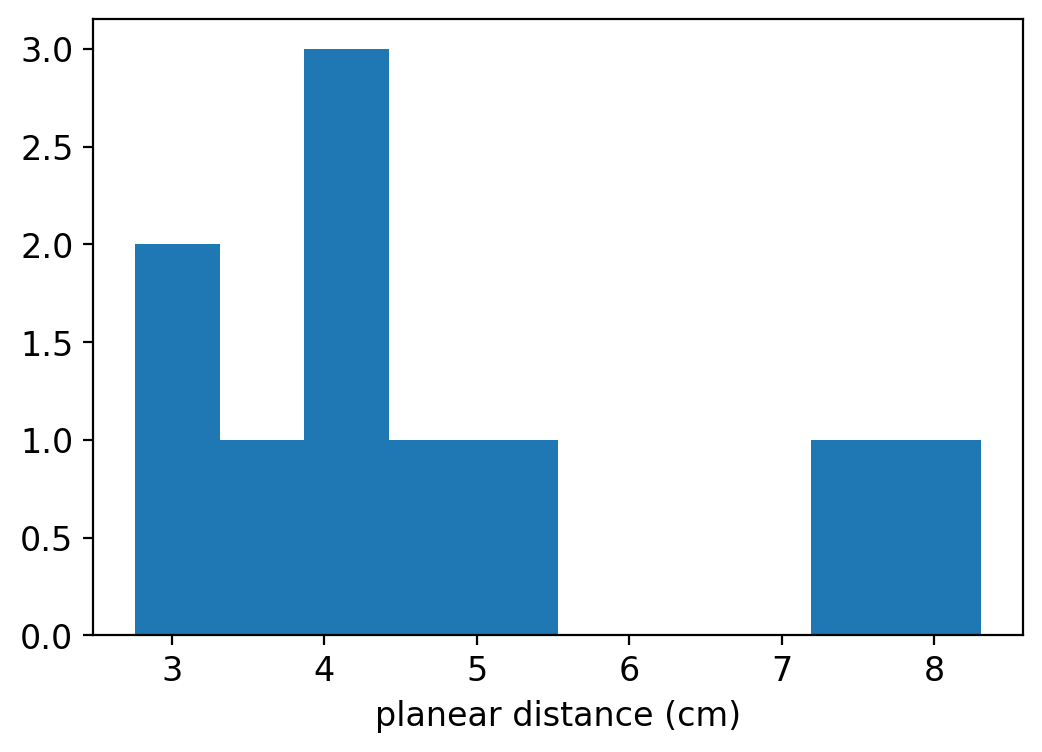

In [95]:
# basically: get the trackster for which we have labels
bigT = get_major_PU_tracksters(
    zip(reco2sim_index_[eid], reco2sim_shared_[eid], reco2sim_score),
    sim_raw_energy_[eid],
)[0]
min_z, max_z = min(vertices_z[bigT]), max(vertices_z[bigT])

x1, x2 = get_trackster_representative_points(
    barycenter_x[bigT],
    barycenter_y[bigT], 
    barycenter_z[bigT],
    min_z,
    max_z
)

in_cone = get_tracksters_in_cone(x1, x2, barycentres, radius=100)

dataset = []
for recoTxId, distance in in_cone:
    if recoTxId == bigT:
       continue    # do not connect to itself

    label = 1 - reco2sim_score[recoTxId][0]
    dataset.append((recoTxId, distance, label))

#len(dataset)
sum(np.array([d[2] for d in dataset]) > 0.2)
distances = [d for _, d, l in dataset if l > 0.2]

plt.figure(figsize=(6, 4))
plt.hist(distances)
plt.xlabel("planear distance (cm)")
plt.show()

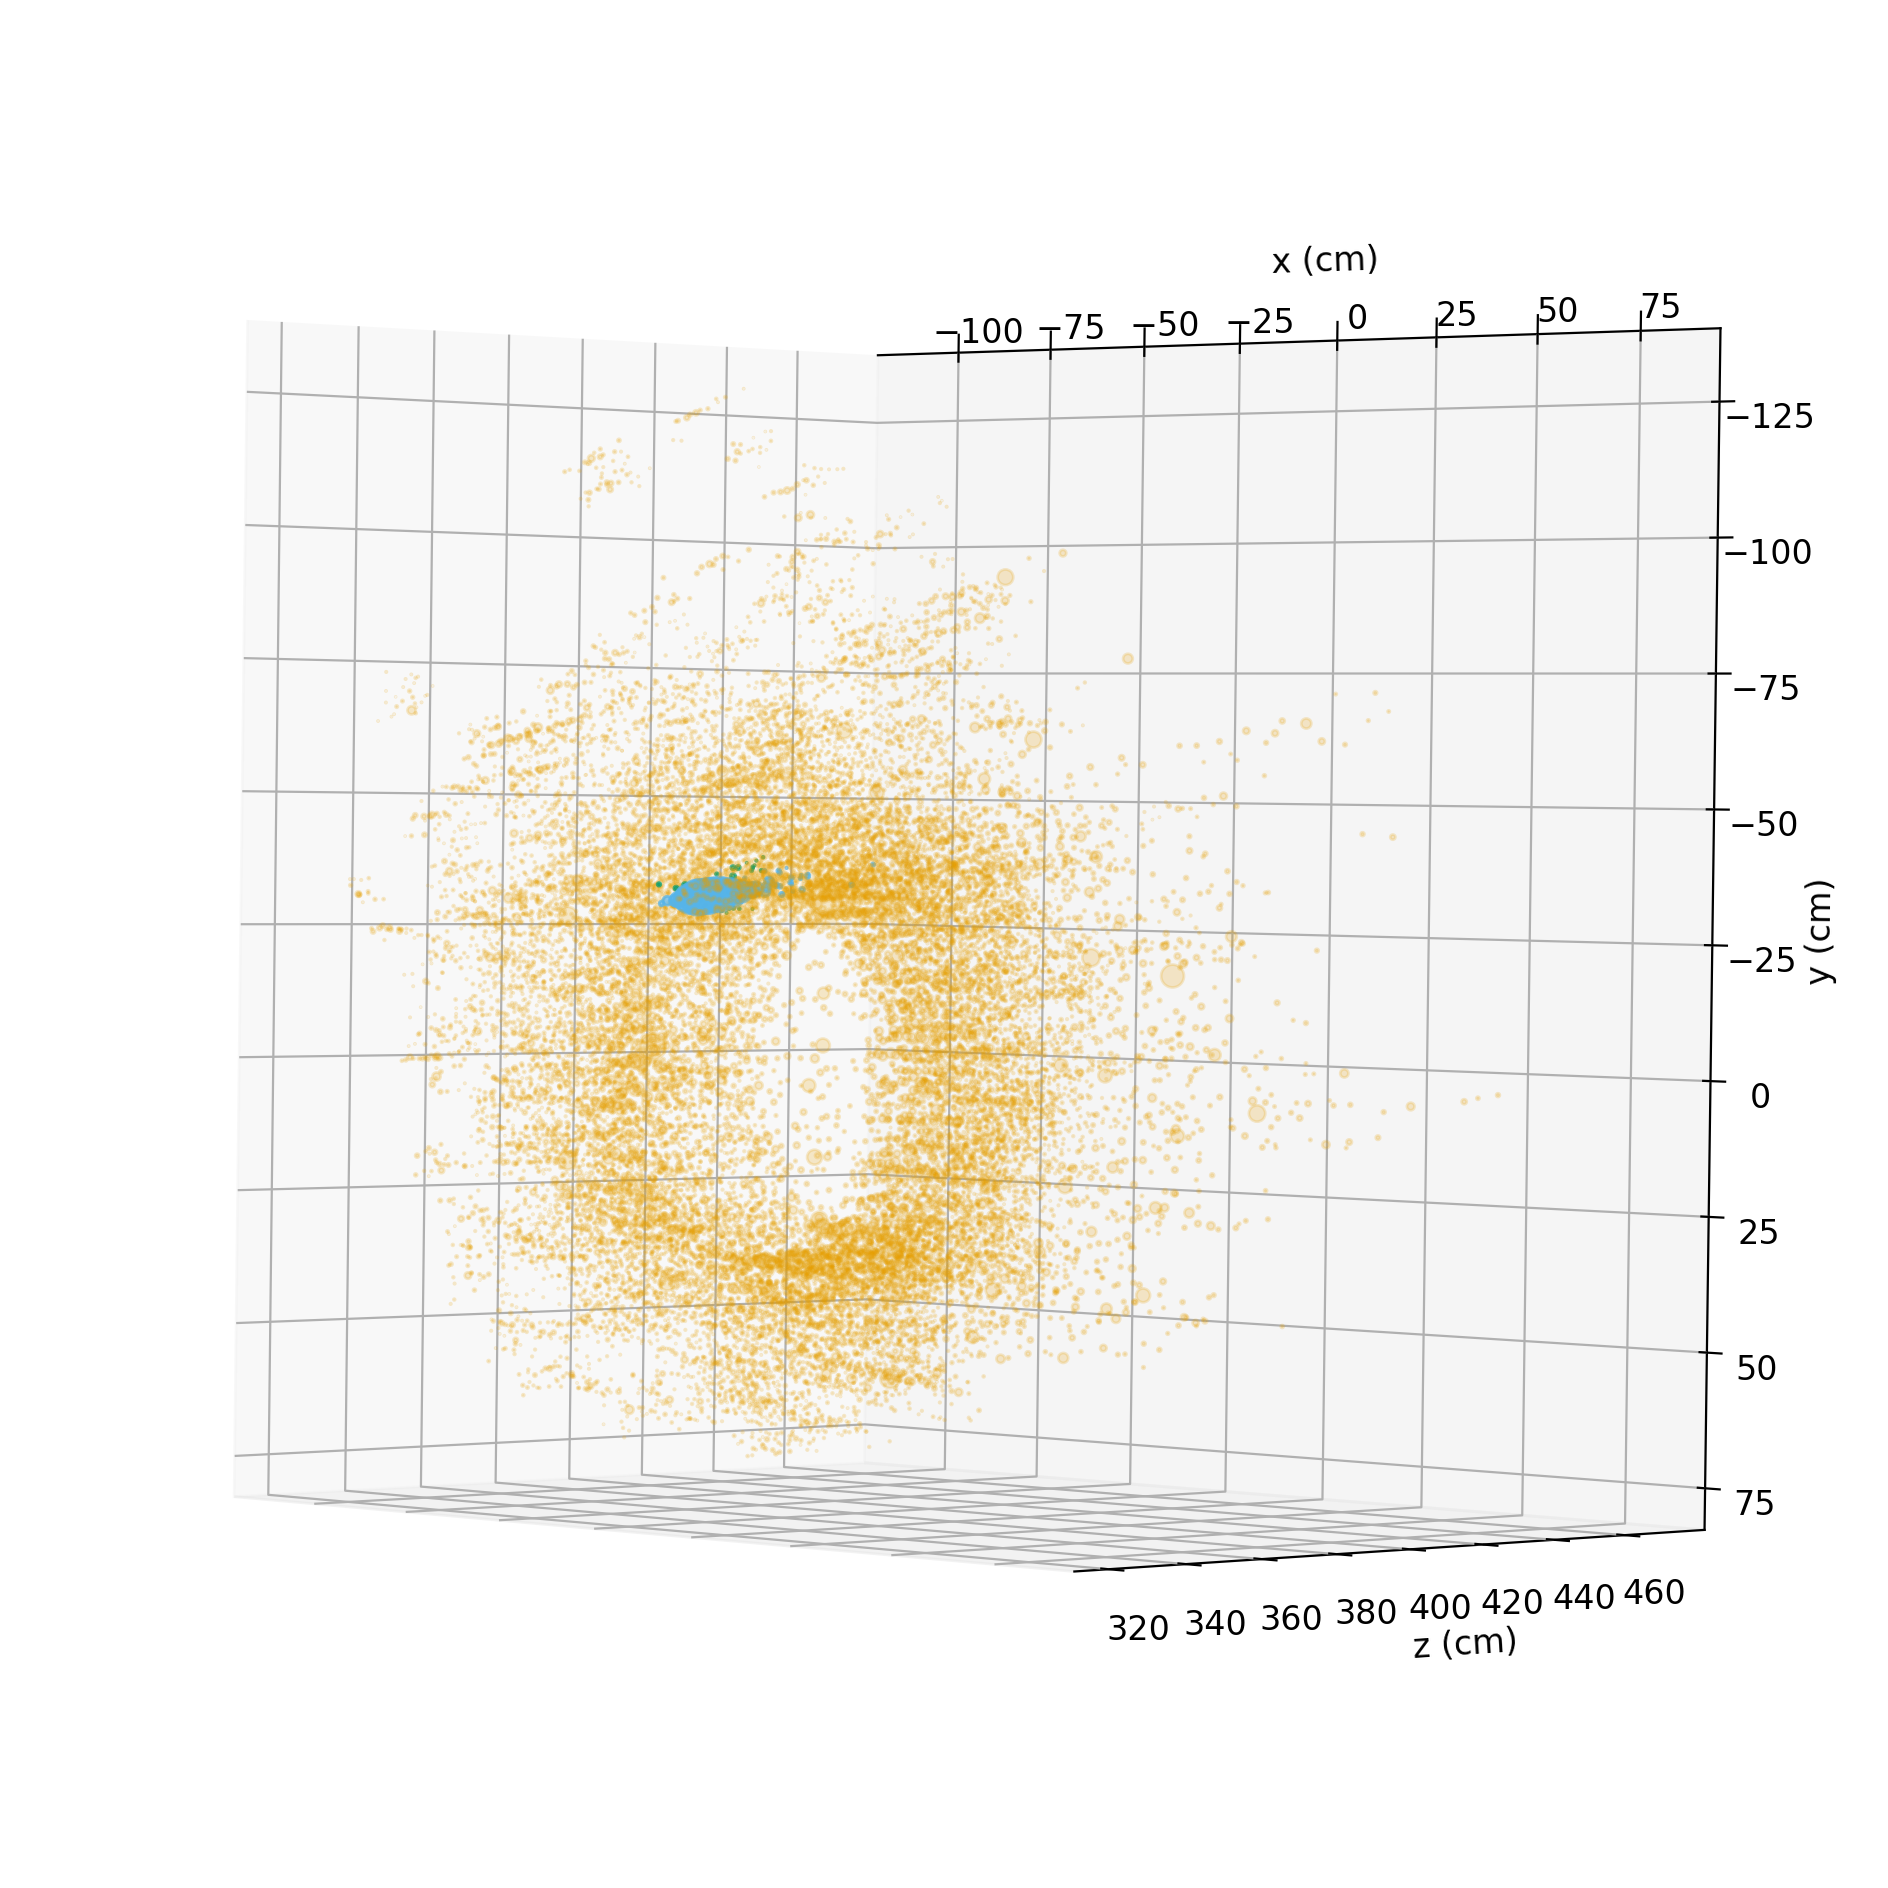

In [98]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
# ax.set_title(f"Reconstruction of a photon in a high-pileup environment")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")
ax.set_zlabel("z (cm)")

bubble_size = 5
pileup_alpha = 0.2
noise_threshold = 0.5

bve = vertices_e[bigT]
ax.scatter(vertices_x[bigT], vertices_y[bigT], vertices_z[bigT], alpha=0.7, s=bve*bubble_size, c="#56B4E9", label=f"{len(bve)} LC: {sum(bve):.2f} GeV")
minp, maxp = get_min_max_z_points(vertices_x[bigT], vertices_y[bigT], vertices_z[bigT])

# ax.plot(
#     (minp[0], maxp[0]),
#     (minp[1], maxp[1]),
#     (minp[2], maxp[2]),
#     c="blue"
# )

for recoTxId, distance, label in dataset:
    vxr = vertices_x[recoTxId]
    vyr = vertices_y[recoTxId]
    vzr = vertices_z[recoTxId]

    rve = vertices_e[recoTxId]
    clr = "#009E73" if label > noise_threshold else "#E69F00"
    alpha = 0.7 if label > noise_threshold else pileup_alpha
    ax.scatter(vxr, vyr, vzr, s=rve*bubble_size, c=clr, label=f"{len(rve)} LC: {sum(rve):.2f} GeV", alpha=alpha)
    minp, maxp = get_min_max_z_points(vxr, vyr, vzr)
    # ax.plot(
    #     (minp[0], maxp[0]),
    #     (minp[1], maxp[1]),
    #     (minp[2], maxp[2]),
    #     c=clr
    # )

ax.view_init(-45, -1, -90)
# plt.legend()
fig.savefig('export/photon-endcap-with-PU.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Big T selection

In [48]:
# for Prod, we don't know the associator score, let's come up with a nice simple heuristic
energies = []
labels = []

for eid in range(10):
    vi = vertices_indices_[eid]
    vertices_z = ak.Array([clusters_z[eid][indices] for indices in vi])

    barycenter_x = barycenter_x_[eid]
    barycenter_y = barycenter_y_[eid]
    barycenter_z = barycenter_z_[eid]

    reco2sim_score = reco2sim_score_[eid]

    bigT = get_major_PU_tracksters(
        zip(reco2sim_index_[eid], reco2sim_shared_[eid], reco2sim_score),
        sim_raw_energy_[eid],
    )

    if not bigT:
        continue

    bigT = bigT[0]
    min_z = min(vertices_z[bigT])
    max_z = max(vertices_z[bigT])

    barycentres = np.array((barycenter_x, barycenter_y, barycenter_z)).T

    x1, x2 = get_trackster_representative_points(
        barycenter_x[bigT],
        barycenter_y[bigT], 
        barycenter_z[bigT],
        min_z,
        max_z
    )

    for recoTxId, distance in get_tracksters_in_cone(x1, x2, barycentres, radius=15):
        labels.append(1 - reco2sim_score[recoTxId][0])
        energies.append(raw_energy_[eid][recoTxId])

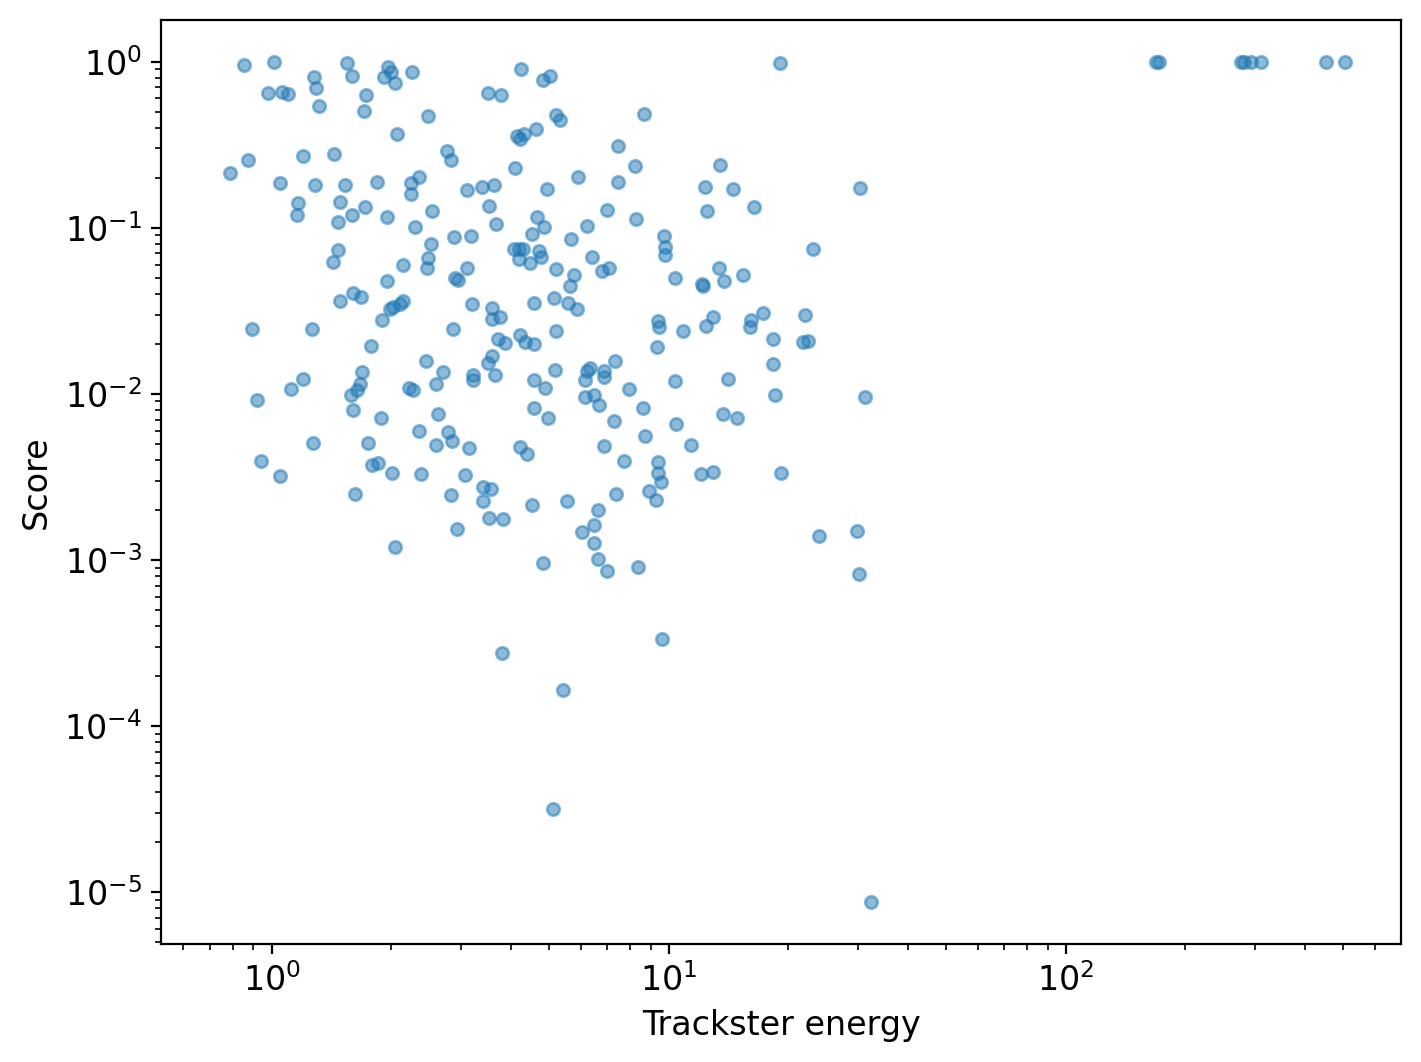

In [49]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# easy - we run it on every photon above 50 Gev (or 100 if we are conservative)
ax.scatter(energies, labels, s=20, alpha=0.5)
ax.set_xlabel("Trackster energy")
ax.set_ylabel("Score")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

# Evaluation

In [50]:
from reco.evaluation import evaluate
import awkward as ak
from reco.plotting import plot_sim_reco

t_indices = vertices_indices_[eid][bigT:bigT+1]
t_energy = ak.Array([clusters_e[eid][indices] for indices in t_indices])
t_multi = vertices_multi_[eid][bigT:bigT+1]

st_indices = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_x = ak.Array([clusters_x[eid][indices] for indices in st_indices])
st_y = ak.Array([clusters_y[eid][indices] for indices in st_indices])
st_z = ak.Array([clusters_z[eid][indices] for indices in st_indices])
st_energy = ak.Array([clusters_e[eid][indices] for indices in st_indices])
st_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

In [51]:
print(f"Baseline (energy {sum(t_energy[0]):.2f} GeV):: ")
Pr, Re, F1 = evaluate(t_indices, st_indices, t_energy, st_energy, t_multi, st_multi)
print(f"\tPrecision: {Pr:.2f} | Recall: {Re:.2f} | F1: {F1:.2f}")

Baseline (energy 504.60 GeV):: 
	Precision: 0.93 | Recall: 0.05 | F1: 0.07


In [52]:
# after connecting the trackster
# create the merge map using the label
selected_t_indexes = [i for i, _, l in dataset if l > 0.2]
selected_t_indexes.append(bigT)

r_indices = ak.Array([ak.flatten(vertices_indices_[eid][selected_t_indexes])])
r_x = ak.Array([ak.flatten([clusters_x[eid][indices] for indices in r_indices])])
r_y = ak.Array([ak.flatten([clusters_y[eid][indices] for indices in r_indices])])
r_z = ak.Array([ak.flatten([clusters_z[eid][indices] for indices in r_indices])])
r_energy = ak.Array([ak.flatten([clusters_e[eid][indices] for indices in r_indices])])
r_multi = [ak.flatten(vertices_multi_[eid][selected_t_indexes])]

print("Reco tracksters:", len(r_indices), "Sim tracksters:", len(st_indices))

Reco tracksters: 1 Sim tracksters: 1


In [53]:
print(f"After connection (energy {sum(r_energy[0]):.2f} GeV):")
Pr, Re, F1 = evaluate(r_indices, st_indices, r_energy, st_energy, r_multi, st_multi)
print(f"\tPrecision: {Pr:.2f} | Recall: {Re:.2f} | F1: {F1:.2f}")

After connection (energy 508.55 GeV):
	Precision: 0.65 | Recall: 0.05 | F1: 0.07


Text(0.5, 0.92, 'Improved reco trackster')

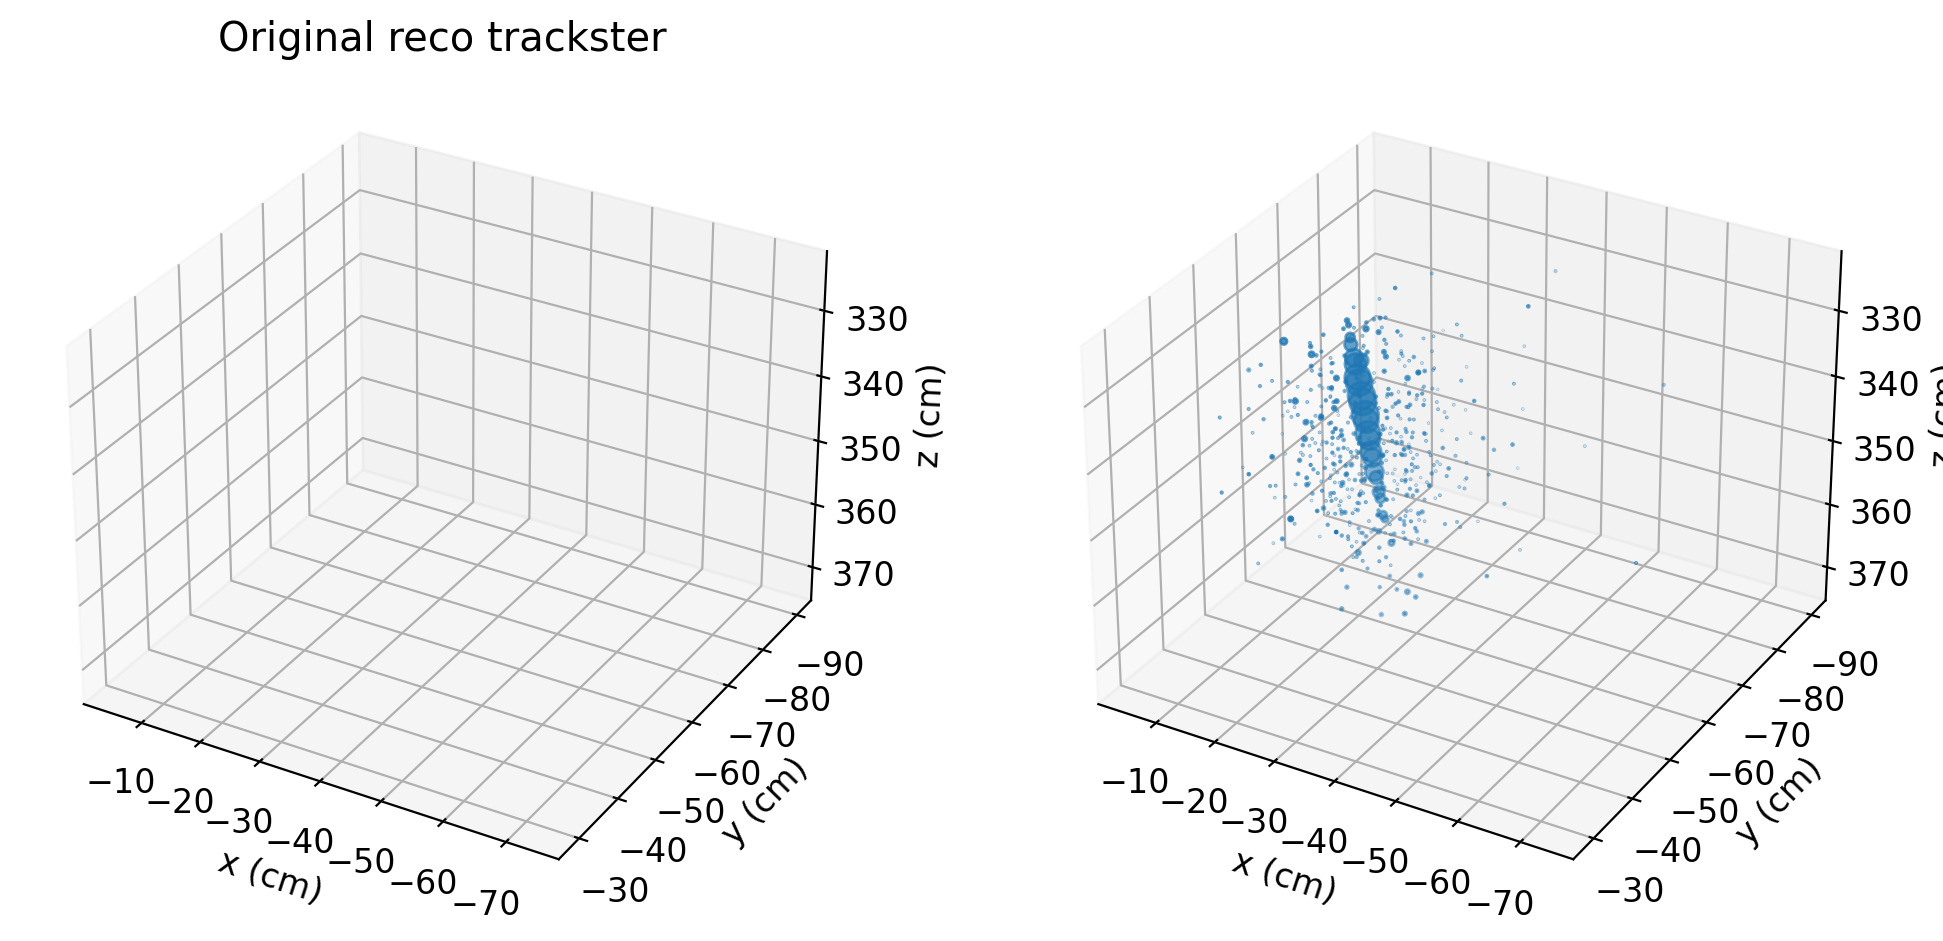

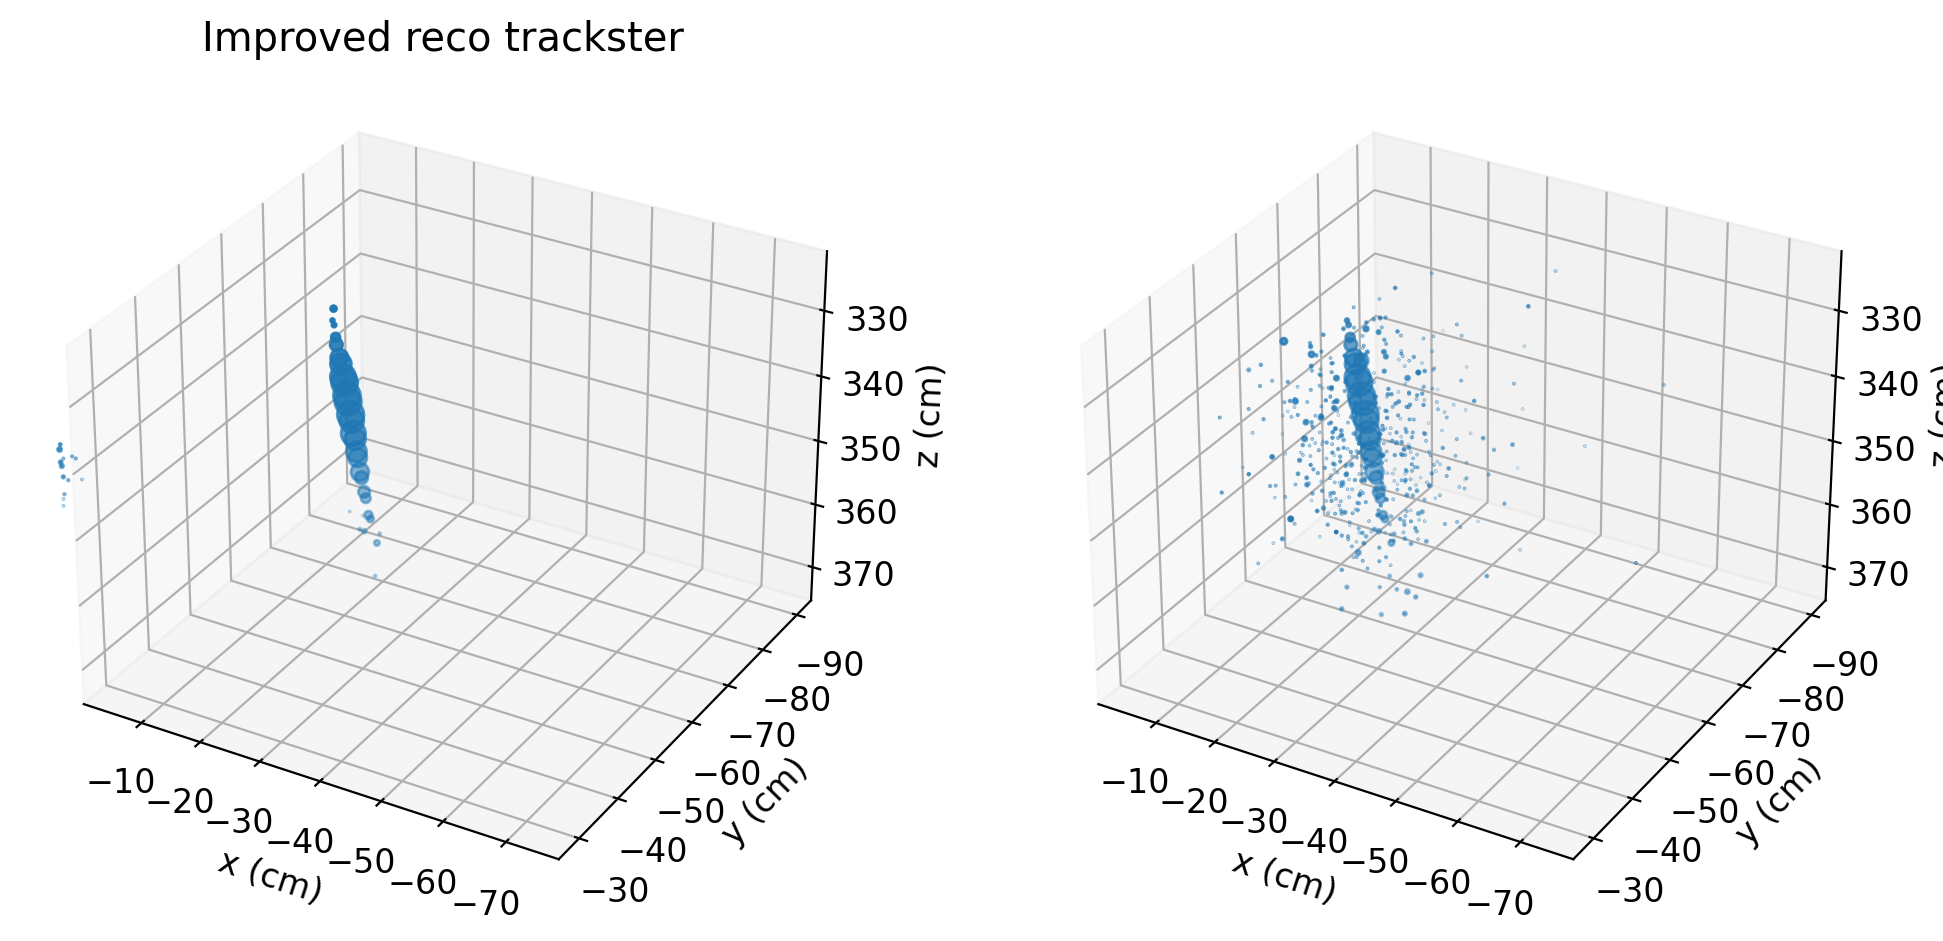

In [54]:
ax1, ax2 = plot_sim_reco(
    vertices_x[bigT:bigT+1],
    vertices_y[bigT:bigT+1],
    vertices_z[bigT:bigT+1],
    vertices_e[bigT:bigT+1],
    st_x,
    st_y,
    st_z,
    st_energy,
    simtracksters["stsSC_vertices_indexes"].array()[eid],
    simtracksters["stsSC_vertices_multiplicity"].array()[eid],
    energy_threshold=0
)

ax1.set_title("Original reco trackster")

ax1, ax2 = plot_sim_reco(
    r_x,
    r_y,
    r_z,
    r_energy,
    st_x,
    st_y,
    st_z,
    st_energy,
    simtracksters["stsSC_vertices_indexes"].array()[eid],
    simtracksters["stsSC_vertices_multiplicity"].array()[eid],
    energy_threshold=0
)

ax1.set_title("Improved reco trackster")

## Feature sensitivity analysis

In [55]:
from reco.datasetPU import TracksterPairsPU

ds = TracksterPairsPU(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=100,
    radius=15
)

In [56]:
ds.x.shape

torch.Size([37004, 43])

In [110]:
from matplotlib.ticker import FormatStrFormatter
from reco.dataset import FEATURE_KEYS

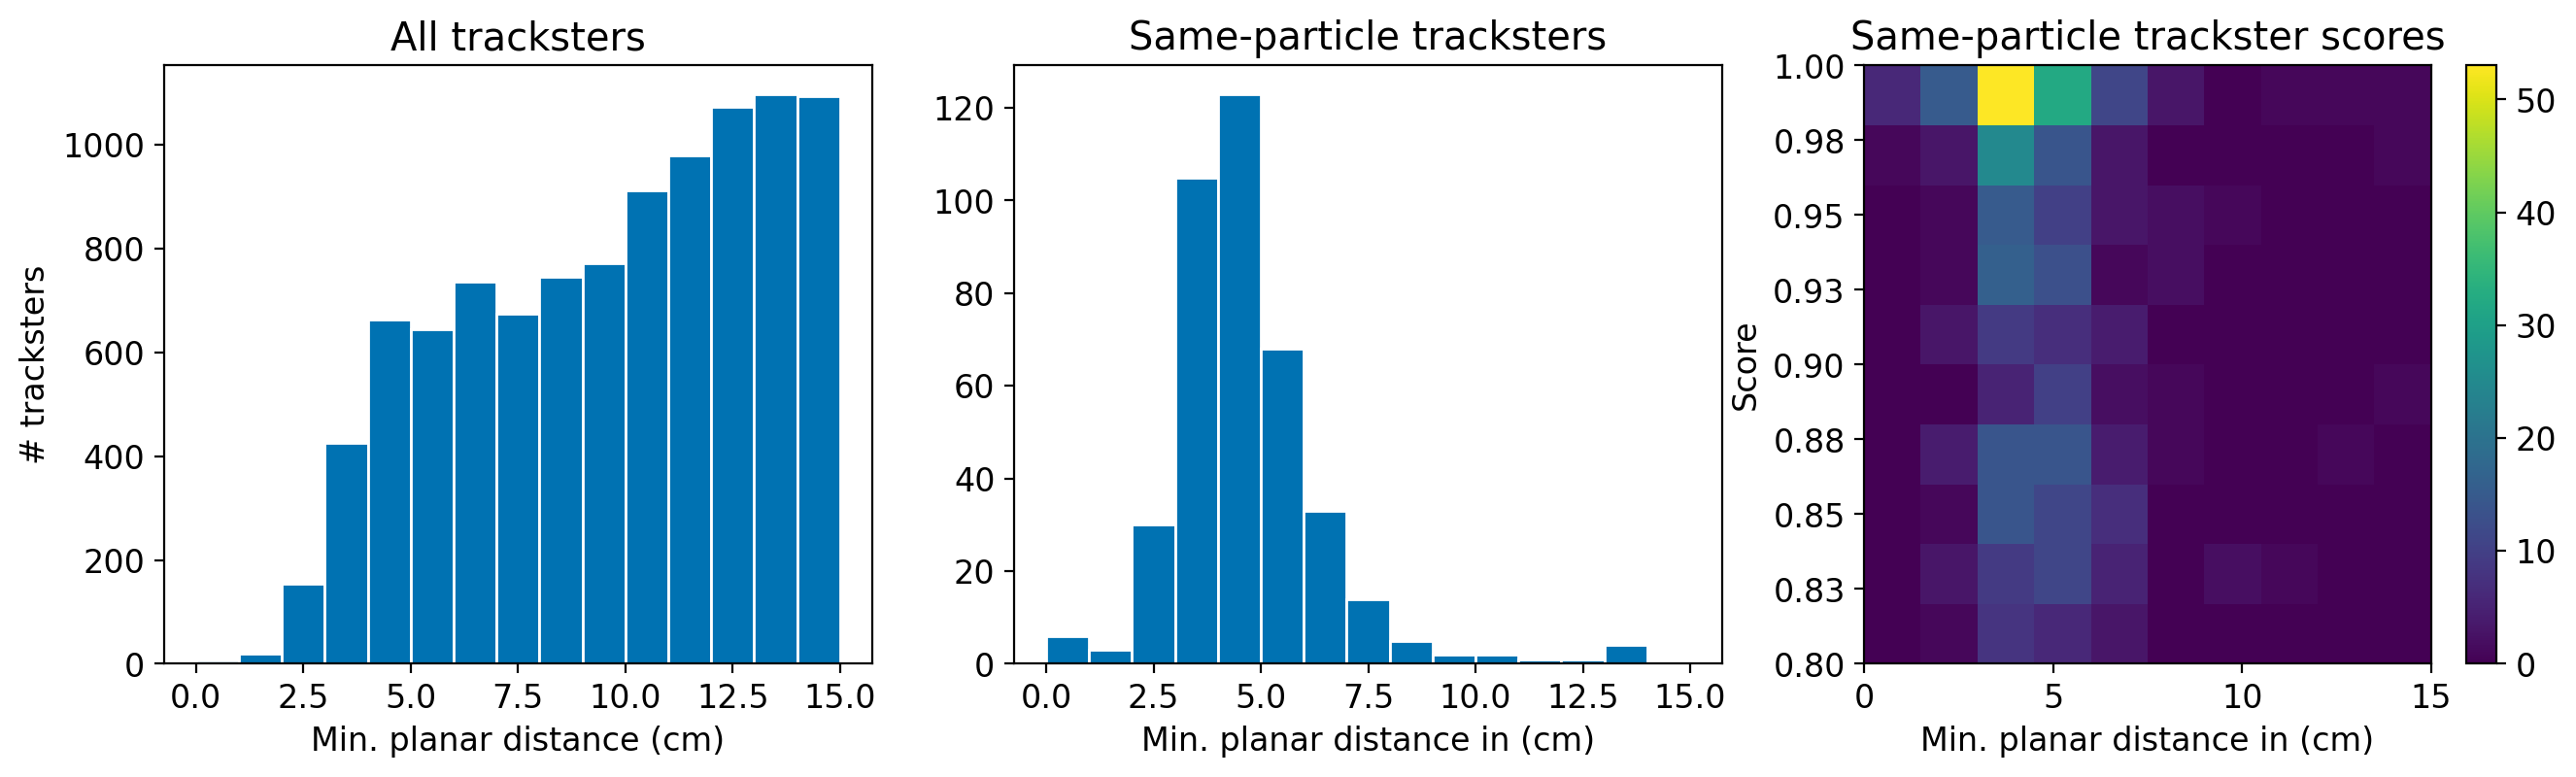

In [111]:
# distance, num-LC big, num-LC small
m = ds.x[:10000,-3:]
positive_idx = ds.y[:10000] >= 0.8
negative_idx = ds.y[:10000] < 0.8

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# ax1 = fig.add_subplot(111)

ax1.hist(m[:,0], edgecolor="white", color="#0072B2", bins=15, range=(0, 15))
ax1.set_title("All tracksters")
ax1.set_xlabel("Min. planar distance (cm)")
ax1.set_ylabel("# tracksters")

ax2.hist(m[:,0][positive_idx], edgecolor="white", color="#0072B2", bins=15, range=(0, 15))
ax2.set_title("Same-particle tracksters")
ax2.set_xlabel("Min. planar distance in (cm)")

im = ax3.hist2d(np.array(m[:,0][positive_idx]), np.array(ds.y[:10000][positive_idx]), range=((0, 15), (0.8, 1)))
ax3.set_title("Same-particle trackster scores")
ax3.set_xlabel("Min. planar distance in (cm)")
ax3.set_ylabel("Score")
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.colorbar(im[3], ax=ax3)


# plt.hist(m[:,0][negative_idx], edgecolor="lightblue")
# plt.title("Negative edges")
# plt.xlabel("Planear distance in CM")
# fig.savefig('export/photon-PU-10k-trackster-distances.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

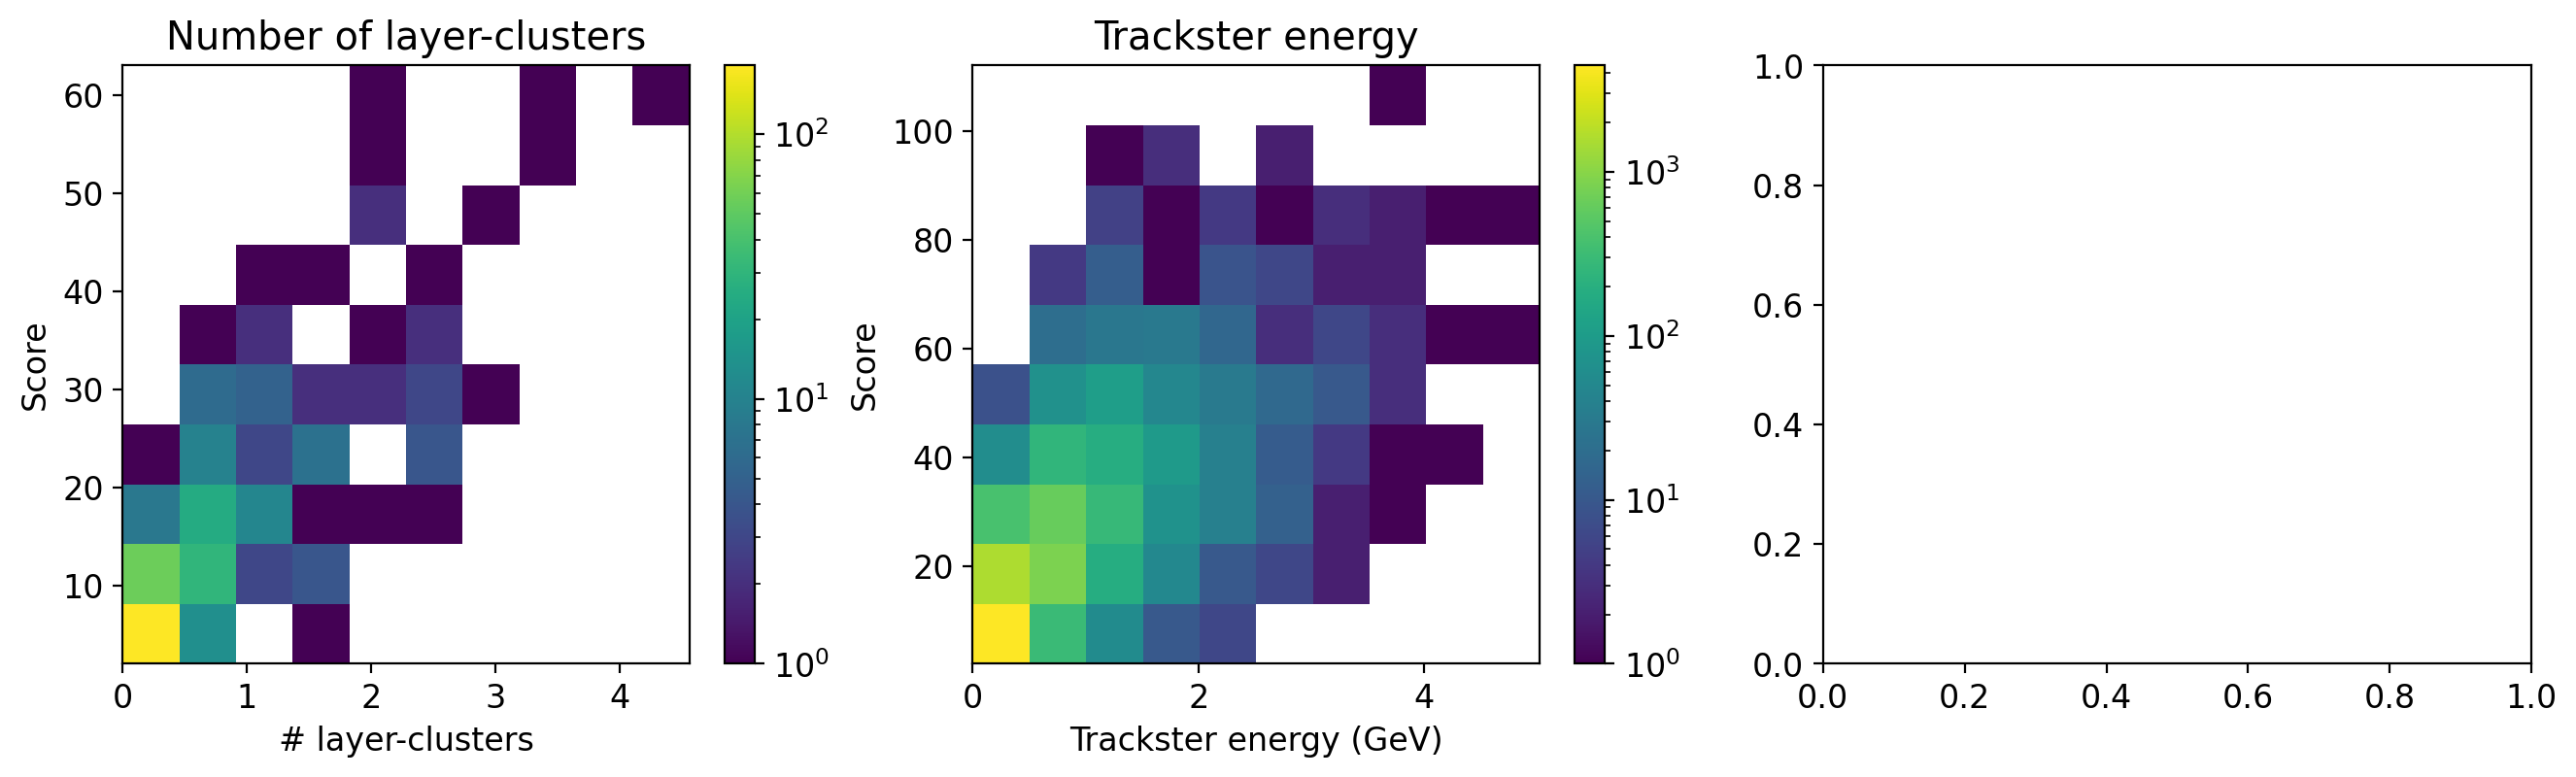

In [137]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

re_idx = 5 + len(FEATURE_KEYS)
im1 = ax1.hist2d(np.array(ds.x[:10000, re_idx][positive_idx]), np.array(m[:,2])[positive_idx], norm="log")
ax1.set_title("Number of layer-clusters")
ax1.set_xlabel("# layer-clusters")
ax1.set_ylabel("Score")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.colorbar(im1[3], ax=ax1)

im2 = ax2.hist2d(np.array(ds.x[:10000, re_idx]), np.array(m[:,2]), norm="log")
ax2.set_title("Trackster energy")
ax2.set_xlabel("Trackster energy (GeV)")
ax2.set_ylabel("Score")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.colorbar(im2[3], ax=ax2)


plt.show()

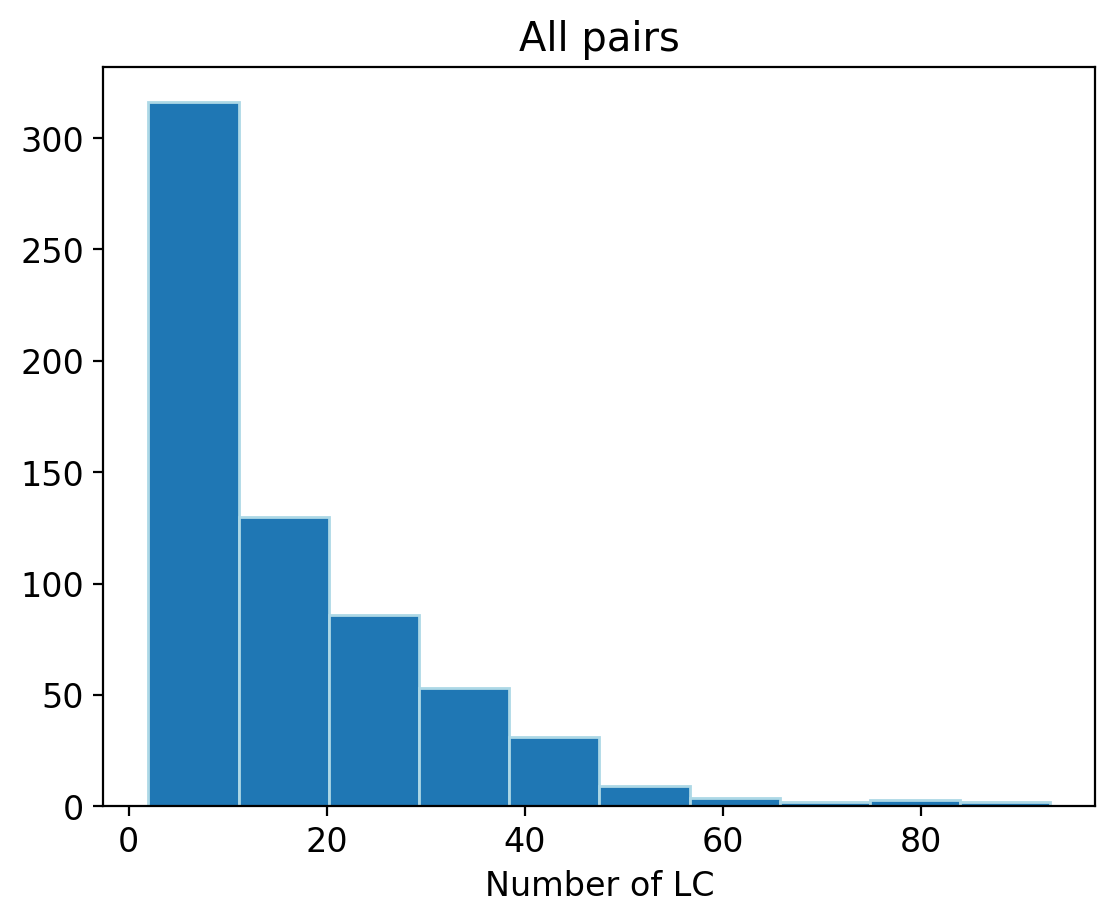

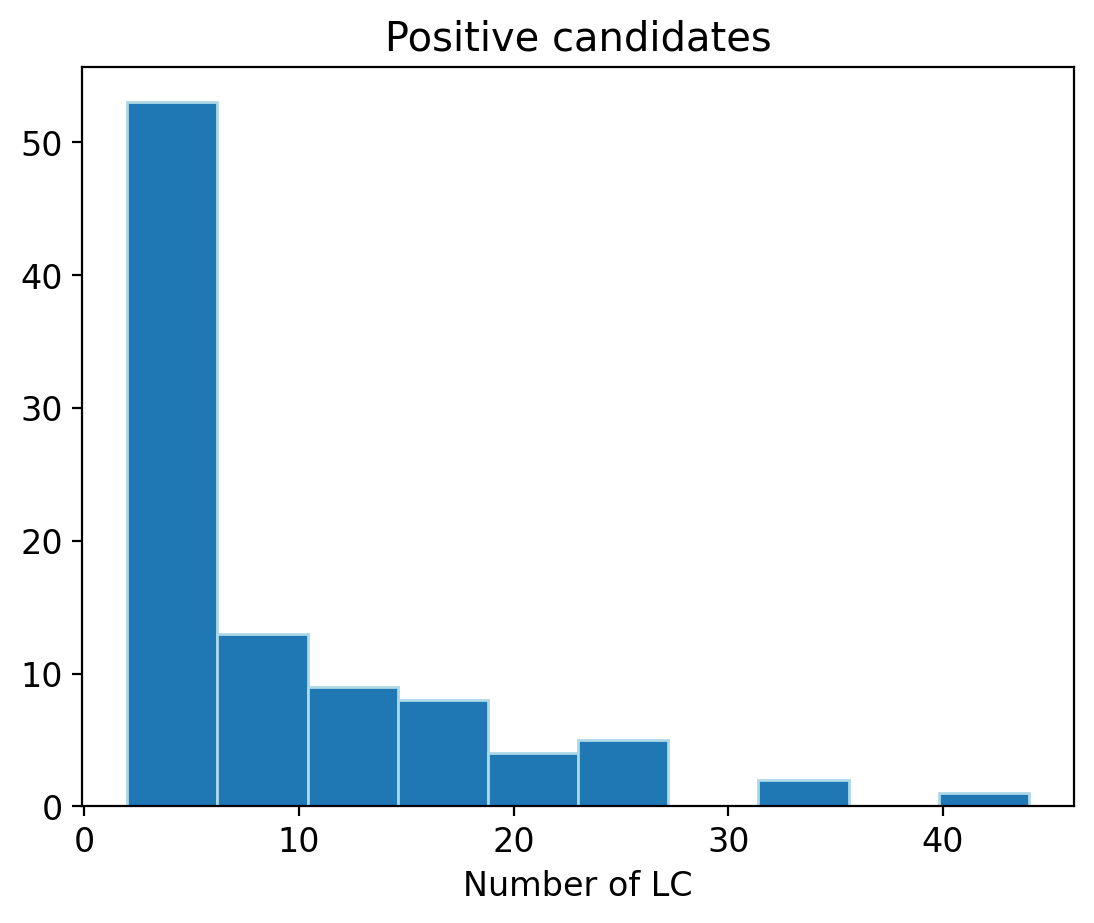

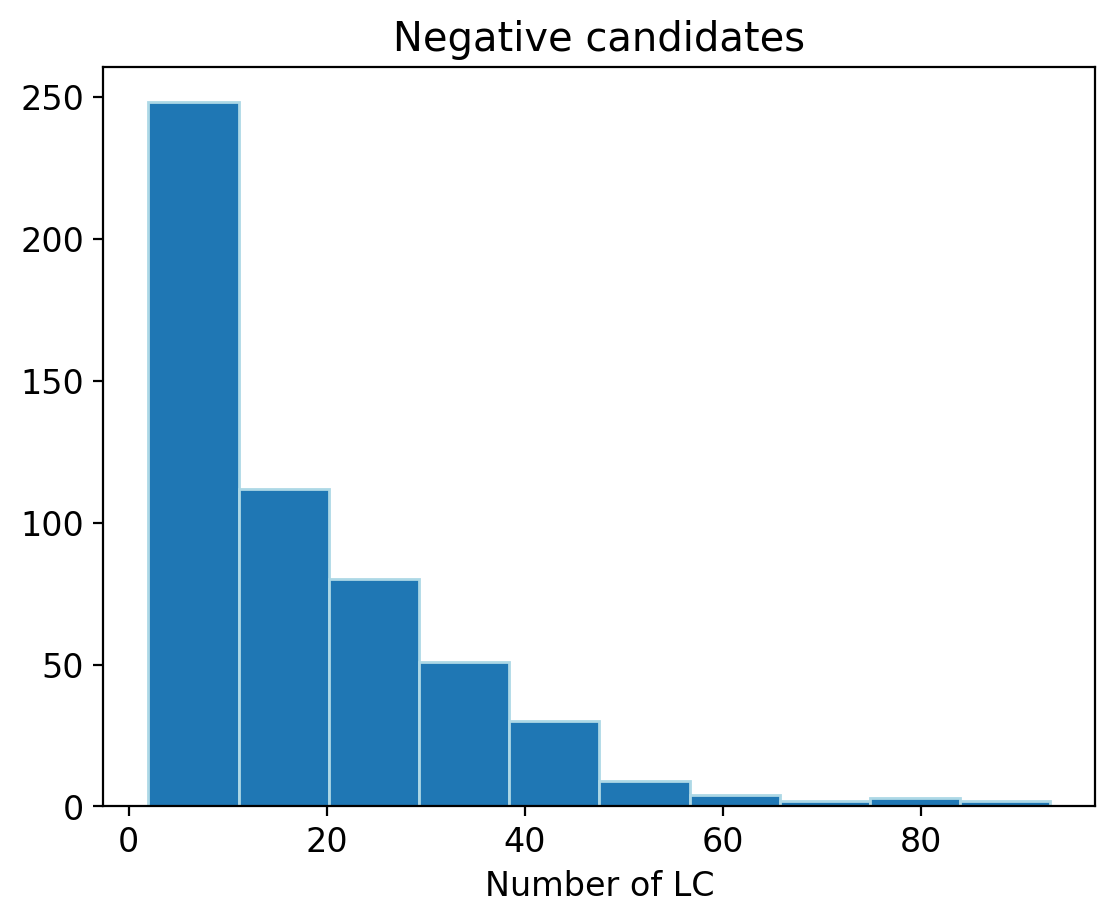

In [6]:
plt.hist(m[:,2], edgecolor="lightblue")
plt.title("All pairs")
plt.xlabel("Number of LC")
plt.show()

plt.hist(m[:,2][positive_idx], edgecolor="lightblue")
plt.title("Positive candidates")
plt.xlabel("Number of LC")
plt.show()


plt.hist(m[:,2][negative_idx], edgecolor="lightblue")
plt.title("Negative candidates")
plt.xlabel("Number of LC")
plt.show()

# --> no difference

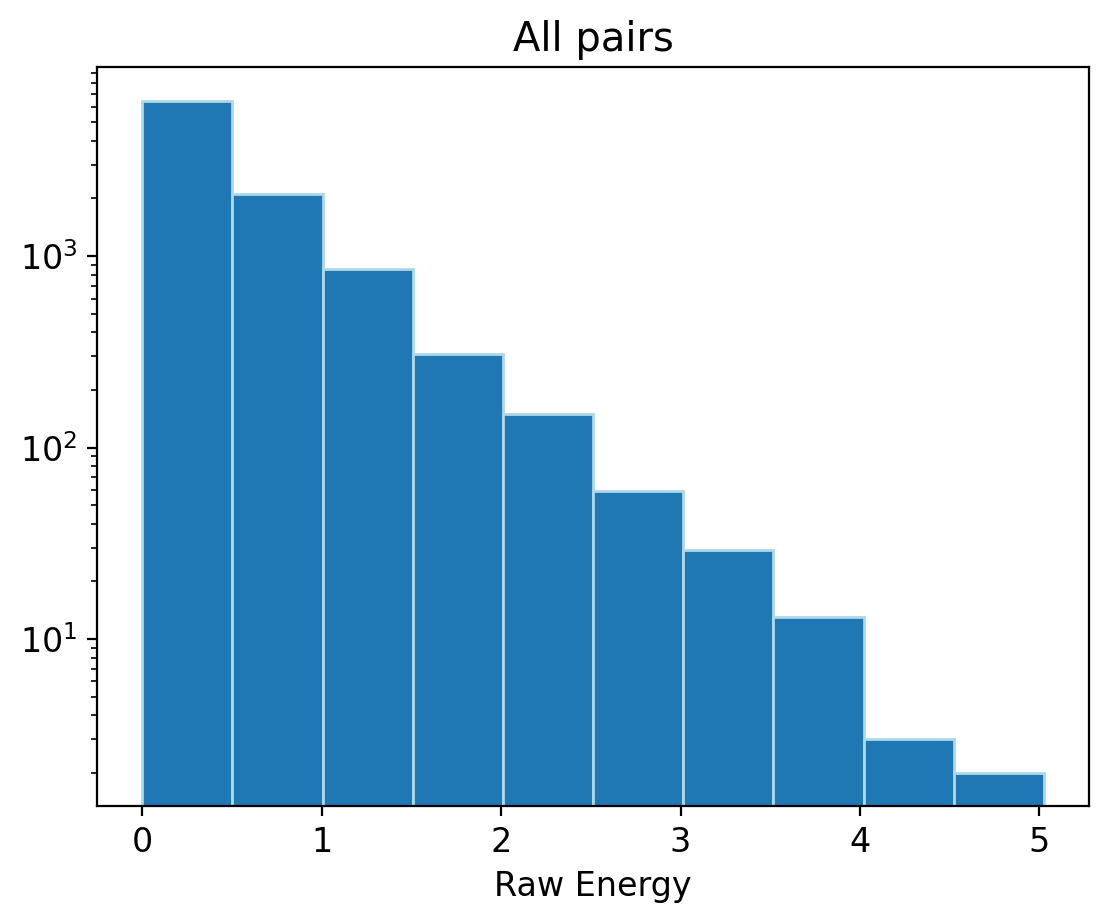

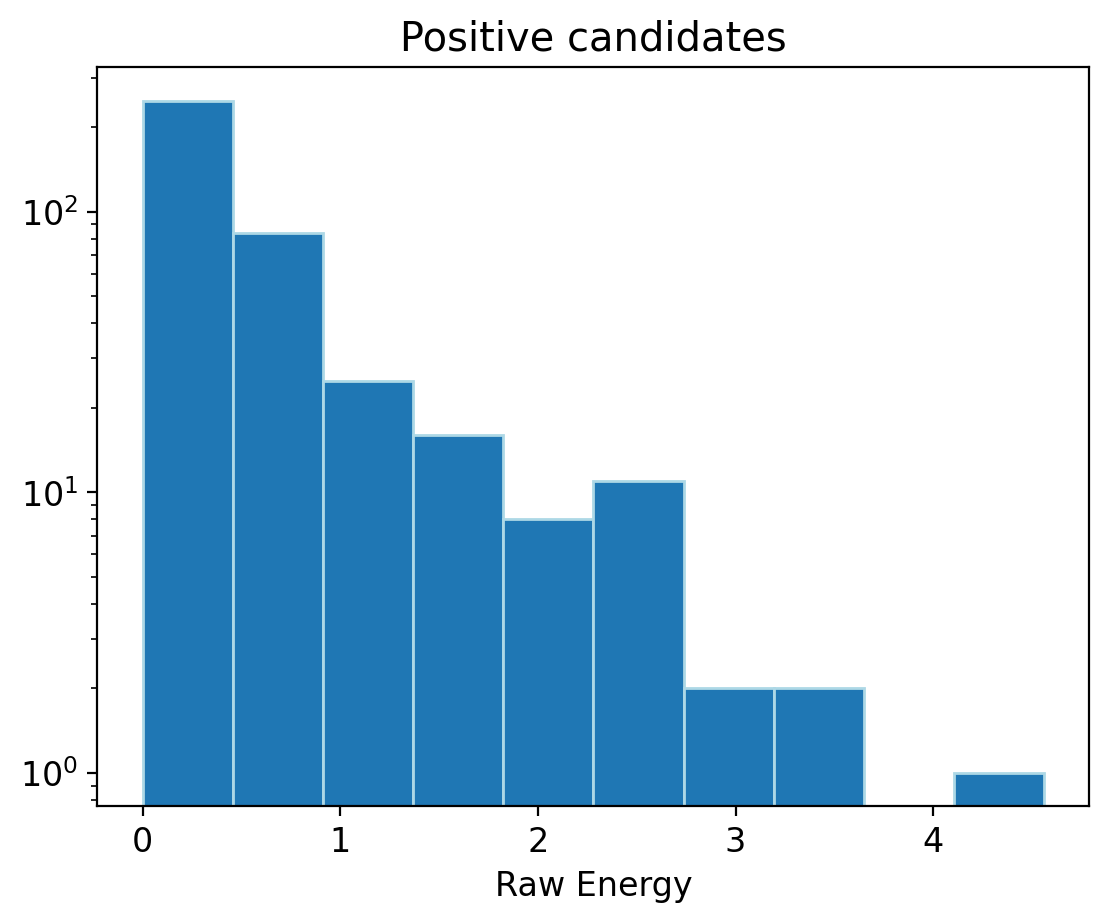

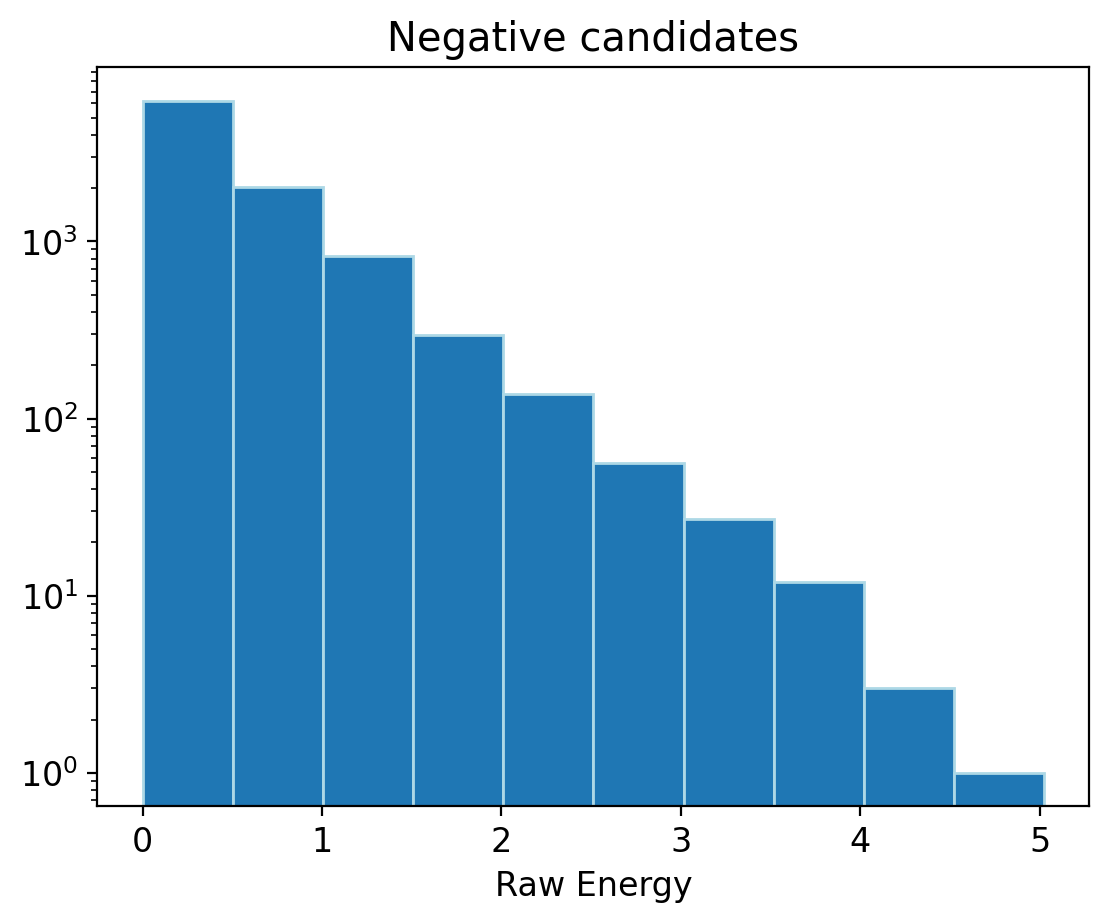

In [99]:

# features of the big trackster
nfeat = len(FEATURE_KEYS)

# index of the feature of interest
f_index = 5 + len(FEATURE_KEYS)

plt.hist(ds.x[:10000, f_index], edgecolor="lightblue")
plt.yscale("log")
plt.title("All pairs")
plt.xlabel("Raw Energy")
plt.show()

plt.hist(ds.x[:10000, f_index][positive_idx], edgecolor="lightblue")
plt.yscale("log")
plt.title("Positive candidates")
plt.xlabel("Raw Energy")
plt.show()

plt.hist(ds.x[:10000, f_index][negative_idx], edgecolor="lightblue")
plt.yscale("log")
plt.title("Negative candidates")
plt.xlabel("Raw Energy")
plt.show()

# --> can't really tell